In [80]:
import numpy as np
from sklearn.datasets import load_digits
import gtda.homology
import gtda.diagrams
import matplotlib.pyplot as plt
from  sklearn.preprocessing import StandardScaler
from topconv import topfiltlearn
import pandas as pd
from topconv import topfiltlearn, filters2diagrams, testmodels, diagrams_2_images, diagrams_2_tpers, concatenate_top_features

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
from PIL import Image
import os, os.path

imgs = []
labels = []
path = "chars"
valid_images = [".jpg",".gif",".png",".tga"]
for f in os.listdir(path)[:5000]:
    labels.append(int(f.split('_')[-1][:-4]))
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs.append(np.ndarray.flatten(np.array(Image.open(os.path.join(path,f)))))

imgs = np.asarray(imgs)    

In [83]:
df = pd.read_csv("chinese_mnist.csv")
df.head(10)

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
5,1,5,10,9,九
6,1,6,10,9,九
7,1,7,10,9,九
8,1,8,10,9,九
9,1,9,10,9,九


In [84]:
print("dataframe rows:", df.shape[0]) 
print("image files :", len(os.listdir("chars")))

dataframe rows: 15000
image files : 15000


In [85]:
# Matching image names
def file_path_col(df):    
    file_path = f"input_{df[0]}_{df[1]}_{df[2]}.jpg" #input_1_1_10.jpg    
    return file_path

# Create file_path column
df["file_path"] = df.apply(file_path_col, axis = 1)
df.head()

,suite_id,sample_id,code,value,character,file_path
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


In [86]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = df.code.values)
val_df, test_df   = train_test_split(df, test_size = 0.5, random_state = 42, shuffle = True, stratify = df.code.values)

print(train_df.shape[0])
print(val_df.shape[0])
print(test_df.shape[0])

12000
7500
7500


In [94]:
import skimage.io
import skimage.transform

file_paths = list(df.file_path)
def read_image(file_paths):
    image = skimage.io.imread("chars\\" + file_paths)
    image = skimage.transform.resize(image, (64, 64), mode="reflect") 
    # THe mode parameter determines how the array borders are handled.    
    return image[:, :]

# One hot encoder, but in 15 classes
def character_encoder(df, var = "character"):
    x = np.stack(df["file_path"].apply(read_image))
    y = pd.get_dummies(df[var], drop_first = False)
    return x, y

In [95]:
x_train, y_train = character_encoder(train_df)
#x_val, y_val = character_encoder(val_df)
#x_test, y_test = character_encoder(test_df)

print(x_train.shape, ",", y_train.shape)
#print(x_val.shape, ",", y_val.shape)
#print(x_test.shape, ",", y_test.shape)

(12000, 64, 64) , (12000, 15)


In [96]:
from skimage.measure import block_reduce
pooled_X = []
for x in x_train:
    pooled_X.append(block_reduce(x,(4,4),np.max))

In [97]:
np.shape(pooled_X)

(12000, 16, 16)

In [98]:
y = train_df['value'].to_numpy()

In [108]:
pooled_X = pooled_X[:1000]
X = x_train[:1000]
y = y[:1000]

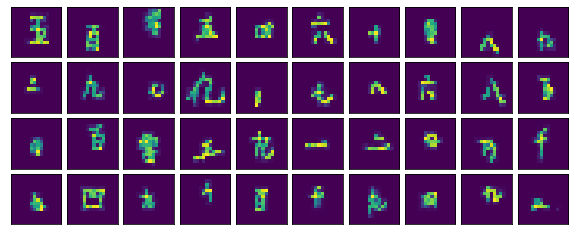

In [109]:
def plot_digits(data):
    fig, axes = plt.subplots(4,10,figsize=(10,4),subplot_kw = {'xticks':[], 'yticks':[]},
                            gridspec_kw = dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i])
plot_digits(pooled_X)

kNN Results:  [0.24850299 0.23123123 0.26426426]
Gradient Boosting Results:  [0.24850299 0.24624625 0.26426426]


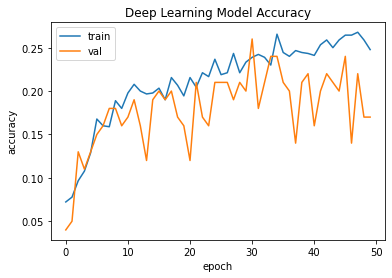

In [110]:
#Turn data into diagrams
D = filters2diagrams(X,[])
#Compute persistent images of diagrams
images = diagrams_2_images(D)
#Concatenate images across filters
con_images = concatenate_top_features(images)
#Test these features on the learning task
testmodels(con_images,y)

kNN Results:  [0.17664671 0.21021021 0.1951952 ]
Gradient Boosting Results:  [0.18263473 0.28828829 0.23723724]


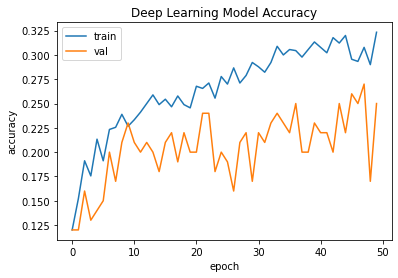

In [111]:
#Turn data into diagrams
D = filters2diagrams(pooled_X,[])
#Compute persistent images of diagrams
images = diagrams_2_images(D)
#Concatenate images across filters
con_images = concatenate_top_features(images)
#Test these features on the learning task
testmodels(con_images,y)

kNN Results:  [0.0988024  0.09309309 0.10510511]
Gradient Boosting Results:  [0.18562874 0.15615616 0.12912913]


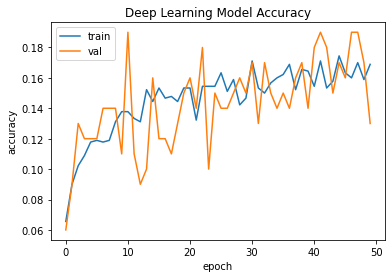

In [112]:
#We can also compute total persistence
tpers = diagrams_2_tpers(D)
#Concatenate this  across filters
con_tpers = concatenate_top_features(tpers)
#Test these features on the learning task
testmodels(con_tpers,y)

kNN Results:  [0.0988024  0.09309309 0.10510511]
Gradient Boosting Results:  [0.18562874 0.15315315 0.14114114]


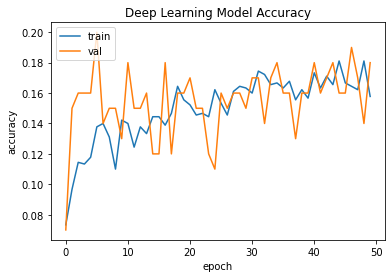

In [114]:
# Using some preset 4x4 filters
from scipy.ndimage import gaussian_filter, sobel, uniform_filter, laplace
A = np.zeros((4,4))
filters = [gaussian_filter(A,sigma=1), sobel(A),uniform_filter(A),laplace(A)]
#Turn data into diagrams
D = filters2diagrams(pooled_X,filters)
#We can also compute total persistence
tpers = diagrams_2_tpers(D)
#Concatenate this  across filters
con_tpers = concatenate_top_features(tpers)
#Test these features on the learning task
testmodels(con_tpers,y)

kNN Results:  [0.16766467 0.18018018 0.14414414]
Gradient Boosting Results:  [0.26347305 0.23123123 0.27027027]


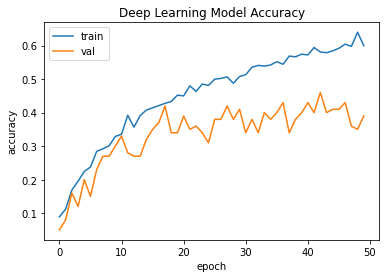

In [115]:
#Using PCA eigenfilters
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA 
patches = []
for im in X[:100]:
    patches.extend(extract_patches_2d(im,(4,4)))
#print(np.shape(patches))
patches = np.reshape(patches,(len(patches),16))
pca = PCA(n_components=16)
pca.fit(patches)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#print(pca.explained_variance_ratio_)
M = np.asarray(pca.components_[:10]).T
filters = []
for i in range(16):
    weights = np.random.uniform(size=10)
    weights = weights/sum(weights)
    filters.append(np.reshape(np.matmul(M,weights),(4,4)))

D = filters2diagrams(pooled_X,filters)
#We can also compute total persistence
tpers = diagrams_2_tpers(D)
#Concatenate this  across filters
con_tpers = concatenate_top_features(tpers)
#Test these features on the learning task
testmodels(con_tpers,y)

kNN Results:  [0.26946108 0.25225225 0.27627628]
Gradient Boosting Results:  [0.31137725 0.3033033  0.31231231]


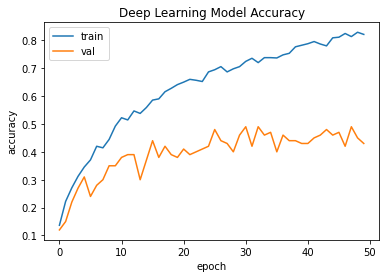

In [116]:
#Using random filters
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

filters = []
for i in range(16):
    filters.append(np.reshape(sample_spherical(1,16),(4,4)))

D = filters2diagrams(pooled_X,filters)
#We can also compute total persistence
tpers = diagrams_2_tpers(D)
#Concatenate this  across filters
con_tpers = concatenate_top_features(tpers)
#Test these features on the learning task
testmodels(con_tpers,y)

kNN Results:  [0.3742515  0.30630631 0.33333333]
Gradient Boosting Results:  [0.32634731 0.36336336 0.30930931]


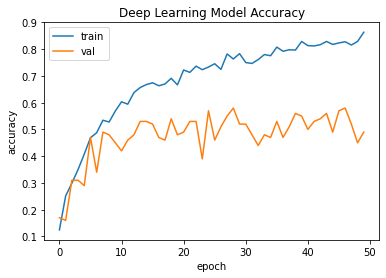

In [117]:
#Using random filters
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

filters = []
for i in range(50):
    filters.append(np.reshape(sample_spherical(1,9),(3,3)))

D = filters2diagrams(pooled_X,filters)
#We can also compute total persistence
tpers = diagrams_2_tpers(D)
#Concatenate this  across filters
con_tpers = concatenate_top_features(tpers)
#Test these features on the learning task
testmodels(con_tpers,y)